Duygu Analizi Görevi

In [1]:
import pandas as pd
import tensorflow as tf
import torch
import numpy as np
import time
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mode

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

from transformers import AutoModel
from sentence_transformers import SentenceTransformer

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [17]:
import pandas as pd

df = pd.read_csv("/content/yorum_utf8.csv")


df = df.rename(columns={'Durum' : 'category', 'Görüş' : 'text'})

label_encoder = LabelEncoder()
df["category"] = label_encoder.fit_transform(df["category"])
df['text'] = df['text'].astype(str)
df['text'] = df['text'].fillna('').astype(str)


In [18]:
df.head()

,text,category
0,"ses kalitesi ve ergonomisi rezalet, sony olduğ...",1
1,hizli teslimat tesekkürler,2
2,ses olayı süper....gece çalıştır sıkıntı yok.....,0
3,geldi bigün kullandık hemen bozoldu hiçtavsiye...,1
4,Kulaklığın sesi kaliteli falan değil. Aleti öv...,1


In [19]:
# Get the count of samples for each class in df
class_counts = df['category'].value_counts()
# Print the counts
print(class_counts)

category
0    4253
1    4238
2    2938
Name: count, dtype: int64


In [20]:
models = []
embeddings_dict = {}

jinaEmbed = SentenceTransformer("jinaai/jina-embeddings-v3", trust_remote_code=True)
task = "classification"
embeddings1 = jinaEmbed.encode(df['text'].tolist(), task=task, prompt_name=task)
embeddings_dict['jina'] = embeddings1

e5Embed = SentenceTransformer('intfloat/multilingual-e5-large-instruct')
embeddings2 = e5Embed.encode(df['text'].tolist())
embeddings_dict['e5'] = embeddings2

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/128 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/140k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

In [21]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Generate improved feature space
def generate_improved_features(embeddings, labels, f=2, k=2, target_size_multiplier=2):
    n_samples, n_original_features = embeddings.shape

    # Calculate the number of new features to achieve the target size multiplier
    num_new_features = int((target_size_multiplier - 1) * n_original_features)

    new_features = []

    for _ in range(num_new_features):
        # Randomly select `f` features
        selected_indices = np.random.choice(n_original_features, f, replace=False)
        selected_features = embeddings[:, selected_indices]

        # Create design matrix based on `k`
        design_matrix = np.hstack([np.ones((n_samples, 1)), selected_features])

        # Fit linear regression to generate new feature
        lr = LinearRegression().fit(design_matrix, labels)
        weights = lr.coef_

        # Generate the new feature
        new_feature = design_matrix @ weights
        new_features.append(new_feature)

    # Stack the new features with the original embeddings
    improved_embeddings = np.hstack([embeddings, np.array(new_features).T])
    return improved_embeddings


labels = df['category'].values
# Concatenate the embeddings
concatenated_embeddings = np.hstack([embeddings1, embeddings2])
embeddings_dict['concatanated'] = concatenated_embeddings

# Generate improved features
target_multiplier1_5 = 1.5  # Example: 1.5x larger embedding space
improved_embeddings_1_5x = generate_improved_features(
    embeddings1, labels, f=2, k=1, target_size_multiplier=target_multiplier1_5
)

embeddings_dict['improved_1.5x'] = improved_embeddings_1_5x

target_multiplier2 = 2  # Example: 2x larger embedding space
improved_embeddings_2x = generate_improved_features(
    embeddings1, labels, f=2, k=1, target_size_multiplier=target_multiplier2
)

embeddings_dict['improved_2x'] = improved_embeddings_2x

target_multiplier3 = 3  # Example: 3x larger embedding space
improved_embeddings_3x = generate_improved_features(
    embeddings1, labels, f=2, k=1, target_size_multiplier=target_multiplier3
)

embeddings_dict['improved_3x'] = improved_embeddings_3x

target_multiplier5 = 5  # Example: 5x larger embedding space
improved_embeddings_5x = generate_improved_features(
    embeddings1, labels, f=2, k=1, target_size_multiplier=target_multiplier5
)

embeddings_dict['improved_5x'] = improved_embeddings_5x
#==--==--==--==

print("Concatanated Embedding Shape:", concatenated_embeddings.shape)
print("Improved Embedding Shape:", improved_embeddings_1_5x.shape)
print("Improved Embedding Shape:", improved_embeddings_2x.shape)
print("Improved Embedding Shape:", improved_embeddings_3x.shape)
print("Improved Embedding Shape:", improved_embeddings_5x.shape)


Concatanated Embedding Shape: (11429, 2048)
Improved Embedding Shape: (11429, 1536)
Improved Embedding Shape: (11429, 2048)
Improved Embedding Shape: (11429, 3072)
Improved Embedding Shape: (11429, 5120)


In [22]:
embeddings_dict['e5'].shape

(11429, 1024)

In [23]:
#firstly training the svm's with each embedding models
#--==--==--==--==--==--==--==--==
svm_models = {}
predictions_SMVS = {}

rf_models = {}
predictions_RF = {}

mlp_models = {}
predictions_MLP = {}

for model_name, embeddings in embeddings_dict.items():
  # if model_name != 'model4':
  #   continue
  # else:
    # Split the data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, df['category'].values, test_size=0.2, random_state=42
    )


    # Train SVM
    #=================================================
    start_time = time.time()
    svm = SVC(probability=True, random_state=42)
    svm.fit(X_train, y_train)
    end_time = time.time()

    # Save the model
    svm_models[model_name] = svm
    print(f"{model_name} - Training and Testing Time SVM: {end_time - start_time:.2f} seconds")


    # Get predictions
    preds = svm.predict(X_test)
    predictions_SMVS[model_name] = preds
    print(f"{model_name} SVM Accuracy: {accuracy_score(y_test, preds):.4f}")
    print(classification_report(y_test, preds))
    #=================================================

    #Train MLP
    #=================================================
    start_time = time.time()
    mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, random_state=42)
    mlp.fit(X_train, y_train)
    end_time = time.time()

    # Save the model
    mlp_models[model_name] = mlp
    print(f"{model_name} - Training and Testing Time MLP: {end_time - start_time:.2f} seconds")


    # Get predictions
    preds = mlp.predict(X_test)
    predictions_MLP[model_name] = preds

    print(f"{model_name} Accuracy MLP: {accuracy_score(y_test, preds):.4f}")
    print(classification_report(y_test, preds))
    #=================================================



jina - Training and Testing Time SVM: 139.92 seconds
jina SVM Accuracy: 0.7577
              precision    recall  f1-score   support

           0       0.81      0.88      0.85       855
           1       0.78      0.83      0.80       852
           2       0.60      0.47      0.53       579

    accuracy                           0.76      2286
   macro avg       0.73      0.73      0.73      2286
weighted avg       0.75      0.76      0.75      2286

jina - Training and Testing Time MLP: 89.53 seconds
jina Accuracy MLP: 0.6907
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       855
           1       0.73      0.72      0.72       852
           2       0.47      0.47      0.47       579

    accuracy                           0.69      2286
   macro avg       0.67      0.67      0.67      2286
weighted avg       0.69      0.69      0.69      2286

e5 - Training and Testing Time SVM: 139.11 seconds
e5 SVM Accuracy: 0.7550
      

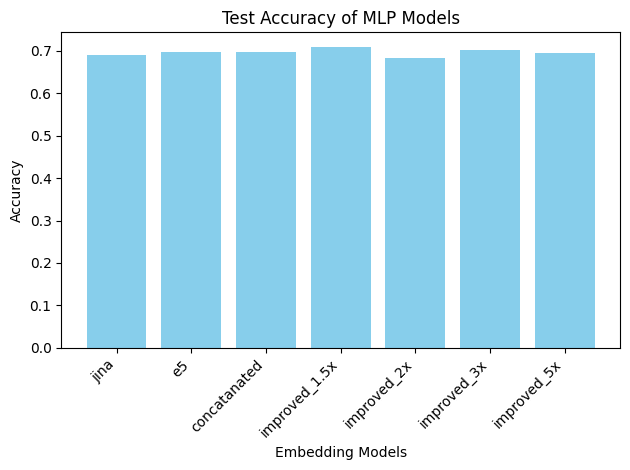

In [24]:
import matplotlib.pyplot as plt

model_names = list(predictions_MLP.keys())
accuracies = [accuracy_score(y_test, preds) for preds in predictions_MLP.values()]

plt.bar(model_names, accuracies, color='skyblue')
plt.xlabel('Embedding Models')
plt.ylabel('Accuracy')
plt.title('Test Accuracy of MLP Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

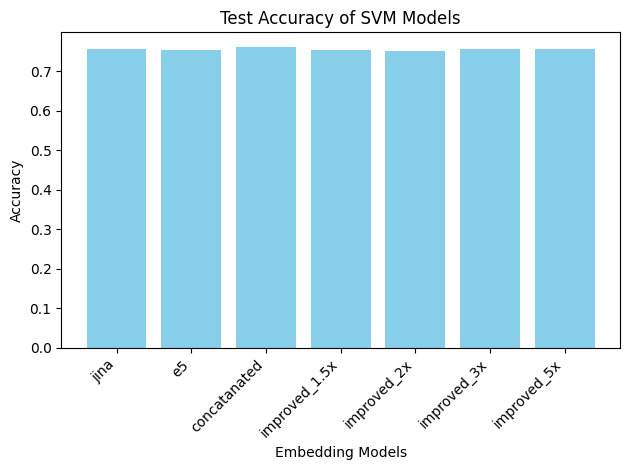

In [26]:
import matplotlib.pyplot as plt

model_names = list(predictions_SMVS.keys())
accuracies = [accuracy_score(y_test, preds) for preds in predictions_SMVS.values()]

plt.bar(model_names, accuracies, color='skyblue')
plt.xlabel('Embedding Models')
plt.ylabel('Accuracy')
plt.title('Test Accuracy of SVM Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

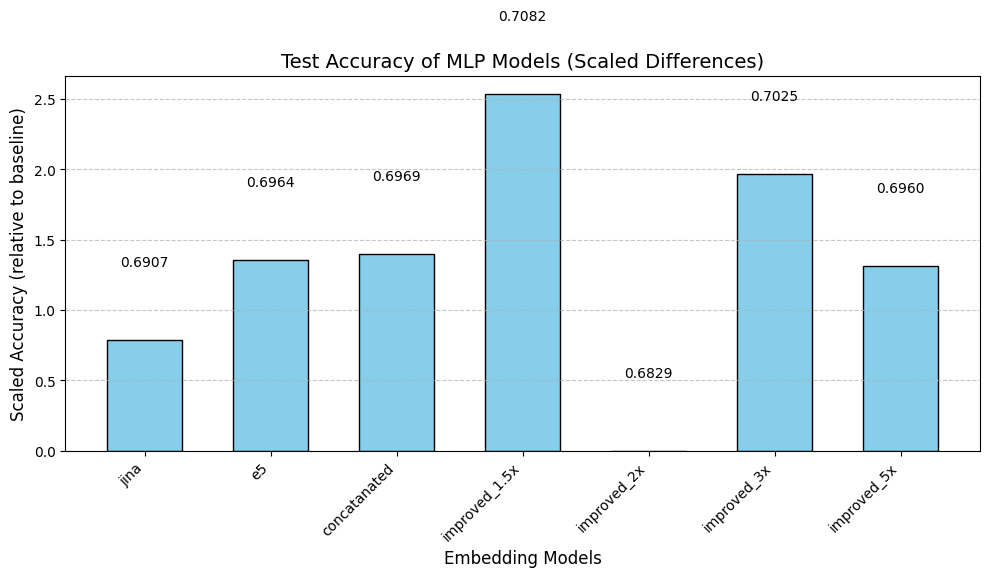

In [29]:
import matplotlib.pyplot as plt

# Example data: Model names and accuracies
model_names = list(predictions_MLP.keys())
accuracies = [accuracy_score(y_test, preds) for preds in predictions_MLP.values()]

# Scale the accuracies (e.g., subtract a baseline and multiply by a factor)
baseline = min(accuracies)  # Set the baseline to the minimum accuracy
scale_factor = 100  # Scaling factor to exaggerate differences
scaled_accuracies = [(acc - baseline) * scale_factor for acc in accuracies]

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, scaled_accuracies, color='skyblue', edgecolor='black', width=0.6)

# Add data labels above the bars for scaled values
for bar, scaled_accuracy, original_accuracy in zip(bars, scaled_accuracies, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
             f'{original_accuracy:.4f}', ha='center', va='bottom', fontsize=10)

# Set labels and title
plt.xlabel('Embedding Models', fontsize=12)
plt.ylabel('Scaled Accuracy (relative to baseline)', fontsize=12)
plt.title('Test Accuracy of MLP Models (Scaled Differences)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


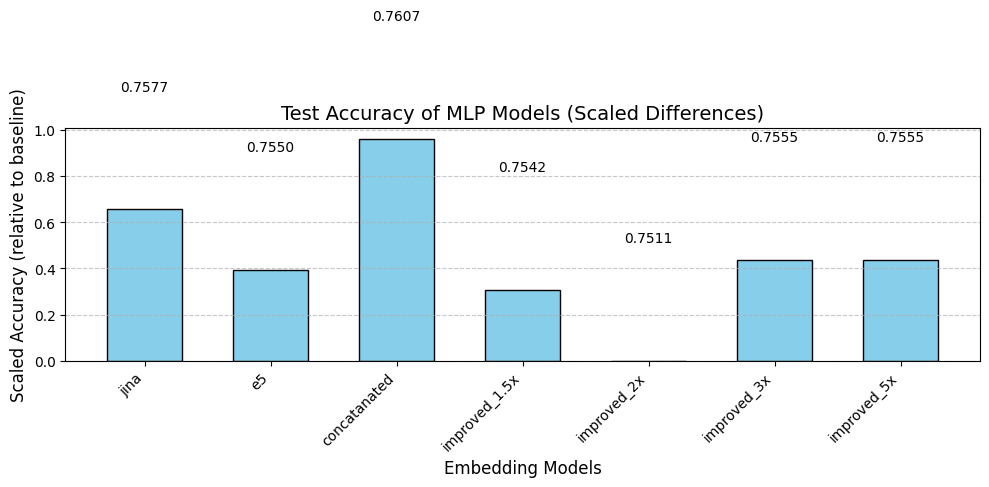

In [31]:
import matplotlib.pyplot as plt

# Example data: Model names and accuracies
model_names = list(predictions_SMVS.keys())
accuracies = [accuracy_score(y_test, preds) for preds in predictions_SMVS.values()]

# Scale the accuracies (e.g., subtract a baseline and multiply by a factor)
baseline = min(accuracies)  # Set the baseline to the minimum accuracy
scale_factor = 100  # Scaling factor to exaggerate differences
scaled_accuracies = [(acc - baseline) * scale_factor for acc in accuracies]

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, scaled_accuracies, color='skyblue', edgecolor='black', width=0.6)

# Add data labels above the bars for scaled values
for bar, scaled_accuracy, original_accuracy in zip(bars, scaled_accuracies, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
             f'{original_accuracy:.4f}', ha='center', va='bottom', fontsize=10)

# Set labels and title
plt.xlabel('Embedding Models', fontsize=12)
plt.ylabel('Scaled Accuracy (relative to baseline)', fontsize=12)
plt.title('Test Accuracy of MLP Models (Scaled Differences)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()